In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import glob



In [12]:
def microseconds_to_mm_ss_str(microseconds):
    minutes = microseconds / 60000000
    minutes_clean = int(minutes)
    seconds = int((minutes - minutes_clean) * 60)

    return f"{minutes_clean:02d}:{seconds:02d}"

In [13]:
scenario_name = 'IND-1'
 # find folder with the scenario name using glob




df_posetrack_zed = pd.read_csv(glob.glob('../../dataset_symlink/'+scenario_name+"*/zed2i_VIO*.csv")[0])
df_px4pos = pd.read_csv(glob.glob('../../dataset_symlink/'+scenario_name+"*/px4_csvlogs/*vehicle_local_position_0.csv")[0])
df_gps_utc = pd.read_csv(glob.glob('../../dataset_symlink/'+scenario_name+"*/px4_csvlogs/*vehicle_gps_position_0.csv")[0])



# add headers to the data
df_posetrack_zed.columns = ['x', 'y', 'z', 'timestamp']

# convert zed ts from milliseconds to microseconds
df_posetrack_zed['timestamp'] = df_posetrack_zed['timestamp'] * 1000

## Fix timestamps


### get offset between px4 timestamp and UTC unix timestamp from GPS

Time UTC offset: 1706885161088984 microseconds


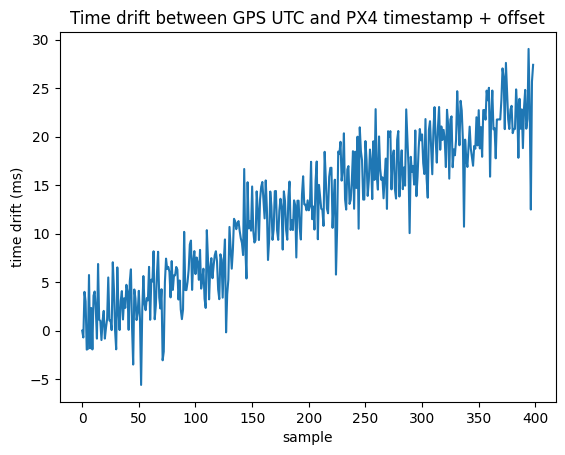

In [14]:
time_utc_offset = df_gps_utc['time_utc_usec'][0] - df_gps_utc['timestamp'][0]

print(f"Time UTC offset: {time_utc_offset} microseconds")

timestamp_rebuilt = df_gps_utc['timestamp'] + time_utc_offset

# plot time drift
plt.ylabel('time drift (ms)')
plt.xlabel('sample')
plt.title('Time drift between GPS UTC and PX4 timestamp + offset')

# plot the time drift to understand how much error in the timestamp is accumulated

plt.plot((timestamp_rebuilt - df_gps_utc['time_utc_usec'])/1000)


In [15]:
# add column to df_px4pos with the rebuilt timestamp
df_px4pos['timestamp_utc'] = df_px4pos['timestamp'] + time_utc_offset

# print log duration to check if it is the same as the online flight review log

# print the duration of the log
print(f'px4 log duration (mm:ss): {microseconds_to_mm_ss_str(df_px4pos["timestamp_utc"].iloc[-1] - df_px4pos["timestamp_utc"].iloc[0])}')

# check zed log duration

# print the duration of the log
print(f'zed Log duration (mm:ss): {microseconds_to_mm_ss_str(df_posetrack_zed["timestamp"].iloc[-1] - df_posetrack_zed["timestamp"].iloc[0])}')


# cut the zed log to match the px4 log
df_posetrack_zed_cut = df_posetrack_zed[df_posetrack_zed['timestamp'] > df_px4pos['timestamp_utc'].iloc[0]]
df_posetrack_zed_cut = df_posetrack_zed_cut[df_posetrack_zed_cut['timestamp'] < df_px4pos['timestamp_utc'].iloc[-1]]
# reset index
df_posetrack_zed_cut = df_posetrack_zed_cut.reset_index(drop=True)

# print difference between min and max timestamp to double check count duration difference with timestamps



# to double check count duration difference with timestamps
duration_diff = abs(df_posetrack_zed["timestamp"].iloc[0] - df_px4pos["timestamp_utc"].iloc[0]) + abs(df_posetrack_zed["timestamp"].iloc[-1] - df_px4pos["timestamp_utc"].iloc[-1])

print(f'duration difference between zed and px4 log (mm:ss): {microseconds_to_mm_ss_str(duration_diff)}')

print("number of samples in zed log: ", len(df_posetrack_zed_cut))
print("number of samples in px4 log: ", len(df_px4pos))



px4 log duration (mm:ss): 03:19
zed Log duration (mm:ss): 03:18
duration difference between zed and px4 log (mm:ss): 00:00
number of samples in zed log:  10304
number of samples in px4 log:  1996


0        1706885395014000
1        1706885395031000
2        1706885395047000
3        1706885395064000
4        1706885395081000
               ...       
10299    1706885593906000
10300    1706885593923000
10301    1706885593940000
10302    1706885593956000
10303    1706885593973000
Name: timestamp, Length: 10304, dtype: int64
0       1706885394712855
1       1706885394813570
2       1706885394912735
3       1706885395008398
4       1706885395101232
              ...       
1991    1706885593811581
1992    1706885593907658
1993    1706885594014088
1994    1706885594108338
1995    1706885594207032
Name: timestamp_utc, Length: 1996, dtype: int64


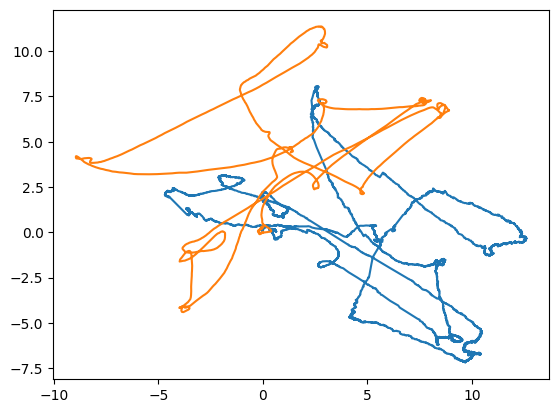

In [16]:
print(df_posetrack_zed_cut['timestamp'])
print(df_px4pos['timestamp_utc'])


plt.plot(df_posetrack_zed_cut['z'], df_posetrack_zed_cut['x'])
plt.plot(df_px4pos['y']-df_px4pos['y'][0], df_px4pos['x']-df_px4pos['x'][0])



(0.0, 220.0)

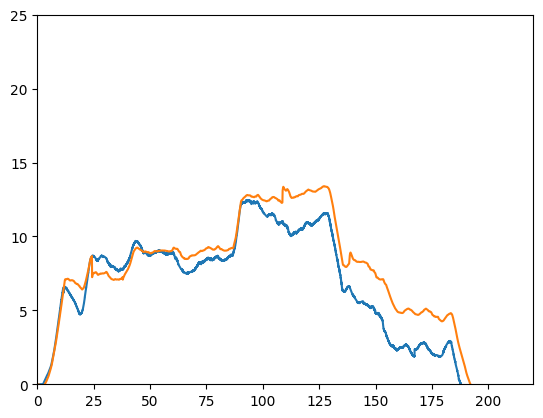

In [17]:
plt.plot((df_posetrack_zed_cut['timestamp']-df_posetrack_zed_cut['timestamp'][0])/1000000, df_posetrack_zed_cut['y'])

plt.plot((df_px4pos['timestamp_utc']-df_px4pos['timestamp_utc'][0])/1000000, -(df_px4pos['z']-df_px4pos['z'][0]))

plt.ylim(0,25)
plt.xlim(0, 220)
